In [ ]:
import torch
import torch.nn as nn

class GaussianRBFNetworkC(nn.Module):
    def __init__(self, gaussian_regularizer, centers_regularizer, weights_regularizer, learnable_centers,
                 centers, device='cpu'):
        super(GaussianRBFNetworkC, self).__init__()

        self.device = device
        self.gaussian_regularizer = gaussian_regularizer
        self.centers_regularizer = centers_regularizer
        self.weights_regularizer = weights_regularizer
        self.centers = centers
        self.learnable_centers = learnable_centers
        self.n_centers = centers.shape[0]
        self.n_features = centers.shape[1]
        # Define learnable parameters
        self.precision_elements = nn.Parameter(torch.randn(self.n_features * (self.n_features + 1) // 2)
                                               .to(self.device))
        if self.learnable_centers == True:
            self.centers = nn.Parameter(centers.to(self.device))
        else:
            self.centers_regularizer = 1e-32
        self.weights = nn.Parameter(torch.randn(self.n_centers)
                                    .to(self.device))

    def compute_precision(self, precision_elements):

        lower_tri = torch.zeros((self.n_features, self.n_features)).to(self.device)
        idx = torch.tril_indices(*lower_tri.shape)
        lower_tri[idx[0], idx[1]] = precision_elements
        precision_matrix = torch.matmul(lower_tri, lower_tri.T)
        return precision_matrix

    def forward(self, X):

        precision_matrix = self.compute_precision(self.precision_elements)
        diff = X[:, None, :] - self.centers.unsqueeze(0)
        Phi = torch.exp(-0.5 * torch.einsum('ijk, kl, ijl -> ij', diff, precision_matrix, diff))
        y_hat = torch.sigmoid(Phi @ self.weights)
        return y_hat

    def evaluate_loss(self, y, y_hat):

        bce_loss = nn.BCELoss()
        loss = bce_loss(y_hat, y)
        reg_gaussian = self.gaussian_regularizer * torch.linalg.norm(self.precision_elements)
        reg_centers = self.centers_regularizer * torch.linalg.norm(self.centers)
        reg_weights = self.weights_regularizer * torch.linalg.norm(self.weights)
        loss = loss + reg_gaussian + reg_centers + reg_weights
        return loss

    def feature_importance(self, precision_matrix):

        eigenvalues, eigenvectors = torch.linalg.eigh(precision_matrix)
        feature_importance = torch.matmul(torch.abs(eigenvectors), eigenvalues)
        return feature_importance / torch.sum(feature_importance), eigenvalues, eigenvectors

In [ ]:
# Import necessary libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset



In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the heart attack dataset
# Make sure to replace 'heart_attack.csv' with your actual file name
data = pd.read_csv('covid_19.csv')

# Preview the dataset
print(data.head())

#data.info()
#data["DATE_DIED"].value_counts()
#data["DEATH"]=[2 if each =="9999-99-99" else 1 for each in data["DATE_DIED"]]
#data.head()
#data.isnull().sum()

# Assume the target variable is named 'target' (1 for heart attack, 0 for no heart attack)
# Adjust feature columns based on your dataset
X = data.drop(columns=['Covid_test_result'])  # Features
y = data['Covid_test_result']  # Target variable

# Convert to numpy arrays
X = X.values
y = y.values

# Split the dataset into training and testing sets
#data = data.fillna(0)
#data = data.dropna(how='all')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_st = torch.tensor(X_train_st, dtype=torch.float32)
X_test_st = torch.tensor(X_test_st, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Check the shapes of the tensors
print(X_train_st.shape, y_train.shape)
print(X_test_st.shape, y_test.shape)


   Ind_ID  Cough_symptoms  Fever  Sore_throat  Shortness_of_breath  Headache  \
0       1               1      0            1                    0         0   
1       2               0      1            0                    0         0   
2       3               0      1            0                    0         0   
3       4               1      0            0                    0         0   
4       5               1      0            0                    0         0   

   Known_contact  Test Date  Covid_test_result  
0              1       2020                  0  
1              1       2020                  1  
2              1       2020                  1  
3              1       2020                  0  
4              2       2020                  0  
torch.Size([3961, 8]) torch.Size([3961])
torch.Size([1698, 8]) torch.Size([1698])


In [ ]:
# Determine RBF centers using k-means clustering
from sklearn.impute import SimpleImputer
n_centers = 16  # Number of RBF centers
kmeans = KMeans(n_clusters=n_centers, random_state=0).fit(X_train_st)
### TO DO: repace kmeans with spectral clustering
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
learnable_centers=False
gaussian_reg, centers_reg, weights_reg= 1e-2, None, 1e-5

In [ ]:
batch_size = 256
step_size = 0.01  #learning rate
model = GaussianRBFNetworkC(gaussian_regularizer=gaussian_reg, centers_regularizer=centers_reg,
                            weights_regularizer=weights_reg, learnable_centers=learnable_centers, centers=centers,)
                            #device='cpu'#)

# Create data loaders
train_dataset = TensorDataset(X_train_st, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training settings
optimizer = optim.Adam(model.parameters(), lr=step_size)
##replace ADAM with GCADAM
n_epochs = 5000

# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_hat = model(batch_X)
        loss = model.evaluate_loss(batch_y, y_hat)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

Epoch 0, Loss: 0.8157988339662552
Epoch 50, Loss: 0.2575681898742914
Epoch 100, Loss: 0.2545496476814151
Epoch 150, Loss: 0.2542187590152025
Epoch 200, Loss: 0.2519675297662616
Epoch 250, Loss: 0.25426353607326746
Epoch 300, Loss: 0.25109343230724335
Epoch 350, Loss: 0.2552699726074934
Epoch 400, Loss: 0.2535147601738572
Epoch 450, Loss: 0.2530849715694785
Epoch 500, Loss: 0.2498574024066329
Epoch 550, Loss: 0.2484925677999854
Epoch 600, Loss: 0.24838728550821543
Epoch 650, Loss: 0.2483623856678605
Epoch 700, Loss: 0.24808194674551487
Epoch 750, Loss: 0.2531801229342818
Epoch 800, Loss: 0.24775842018425465
Epoch 850, Loss: 0.25349894259124994
Epoch 900, Loss: 0.2493112850934267
Epoch 950, Loss: 0.24958048667758703
Epoch 1000, Loss: 0.2502758465707302
Epoch 1050, Loss: 0.2494288608431816
Epoch 1100, Loss: 0.2519175224006176
Epoch 1150, Loss: 0.2497744131833315
Epoch 1200, Loss: 0.24662895686924458
Epoch 1250, Loss: 0.2531491033732891
Epoch 1300, Loss: 0.2489242283627391
Epoch 1350, Loss

In [ ]:
#Evaluate the model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_st).numpy() > 0.5
    y_test_pred = model(X_test_st).numpy() > 0.5
    # Convert y_train and y_test to NumPy arrays to match y_train_pred and y_test_pred
y_train = y_train.numpy()  # Convert y_train to NumPy array
y_test = y_test.numpy()    # Convert y_test to NumPy array


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 0.9171926281242111
Test Accuracy: 0.9216725559481743


In [ ]:
# Extract feature importance
precision_matrix = model.compute_precision(model.precision_elements)
feature_importance1, eigenvalues, eigenvectors = model.feature_importance(precision_matrix)

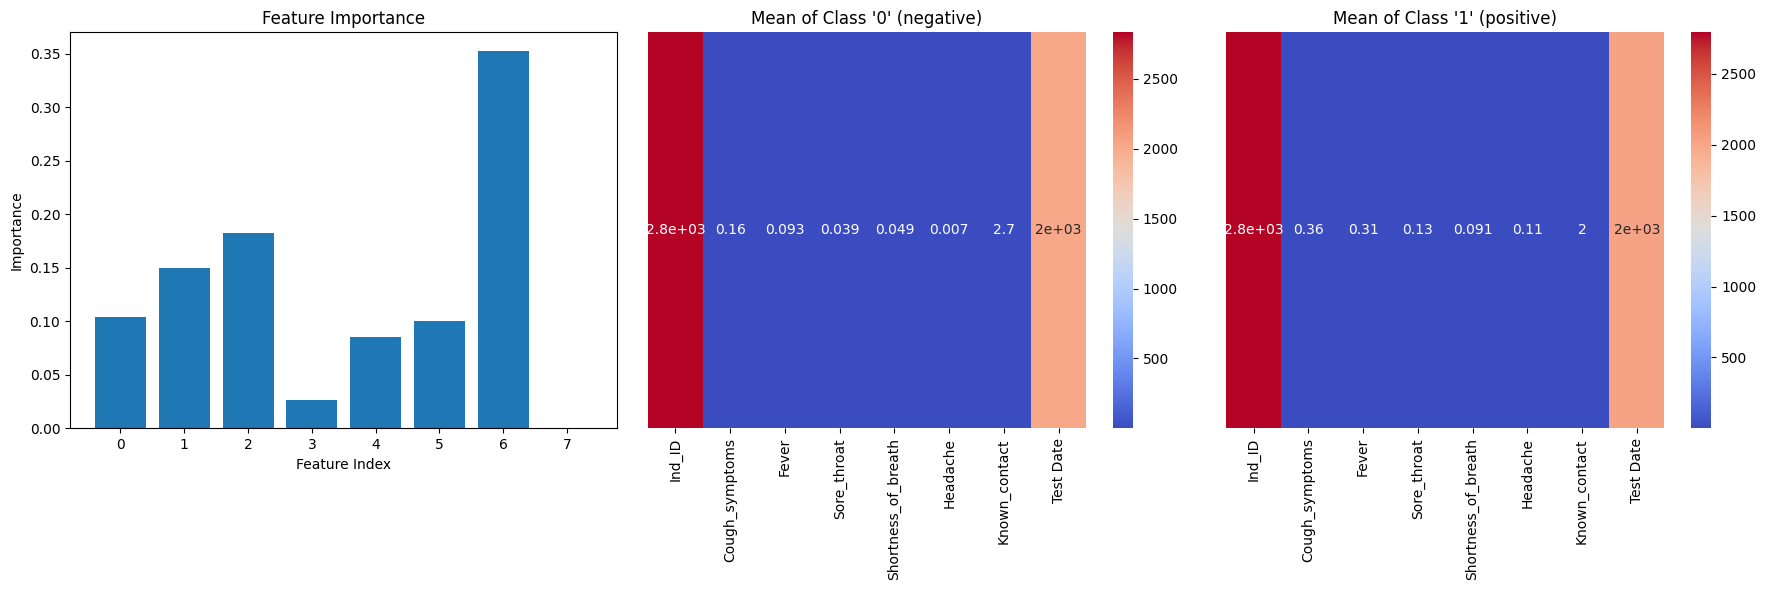

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Assuming the heart dataset is loaded, and the model provides feature_importance values.
# Also assuming you have trained an ML model that outputs feature importance (like RandomForest, SVM, or any other).
# For example, feature_importance can be extracted using `model.feature_importances_` from tree-based models.

# Example feature_importance (assuming it is a torch tensor from your model)
# You need to replace this with actual feature importance from your model
#feature_importance = torch.rand(13)  # Assuming 13 features in the heart dataset

# Detach if required and convert to numpy array
feature_importance = feature_importance1.detach().numpy()

# Assuming X is the feature matrix and y is the target
# Replace X and y with actual data from your heart dataset
# For example, X_train, y_train from the split step
mean_no_disease = X[y == 0].mean(axis=0)  # Mean of class '0' (no heart disease)
mean_disease = X[y == 1].mean(axis=0)     # Mean of class '1' (heart disease)

# Plot the feature importance and class means
plt.figure(figsize=(18, 6))

# Plot 1: Feature Importance as a bar plot
plt.subplot(1, 3, 1)
plt.title("Feature Importance")
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(np.arange(len(feature_importance)))

# Plot 2: Mean of Class '0' (No Heart Disease) as a heatmap
plt.subplot(1, 3, 2)
plt.title("Mean of Class '0' (negative)")
sns.heatmap(mean_no_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])

# Plot 3: Mean of Class '1' (Heart Disease) as a heatmap
plt.subplot(1, 3, 3)
plt.title("Mean of Class '1' (positive)")
sns.heatmap(mean_disease.reshape(1, -1), cmap='coolwarm', annot=True, cbar=True, xticklabels=data.columns[:-1])
plt.yticks([])

# Show the plots
plt.tight_layout()
plt.show()


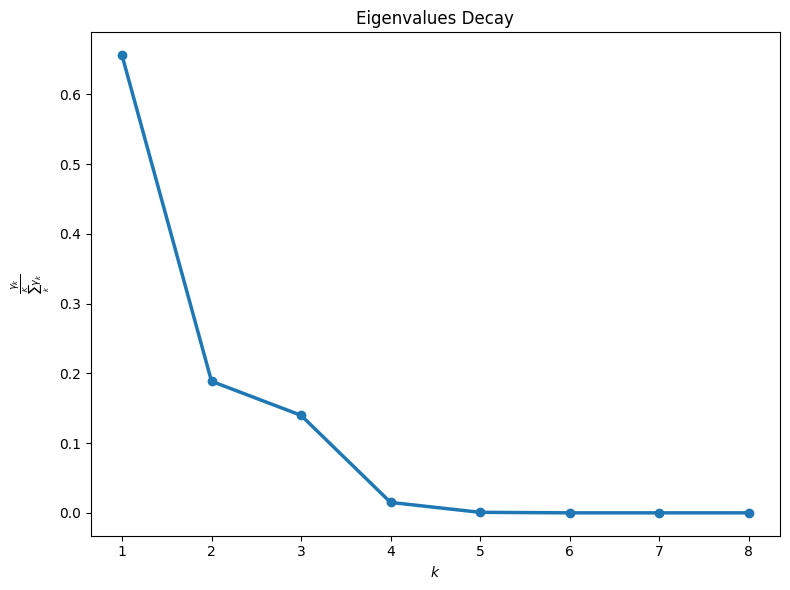

In [ ]:
# Plot eigenvalues decay
gammas = eigenvalues.detach().numpy()[::-1] # sort eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(gammas) + 1), gammas / np.sum(gammas), marker='o', linestyle='-', linewidth=2.5)
plt.xlabel('$k$')
plt.title("Eigenvalues Decay")
plt.ylabel(r'$\frac{\gamma_k}{\sum_k^K \gamma_k}$')
plt.tight_layout()
plt.show()

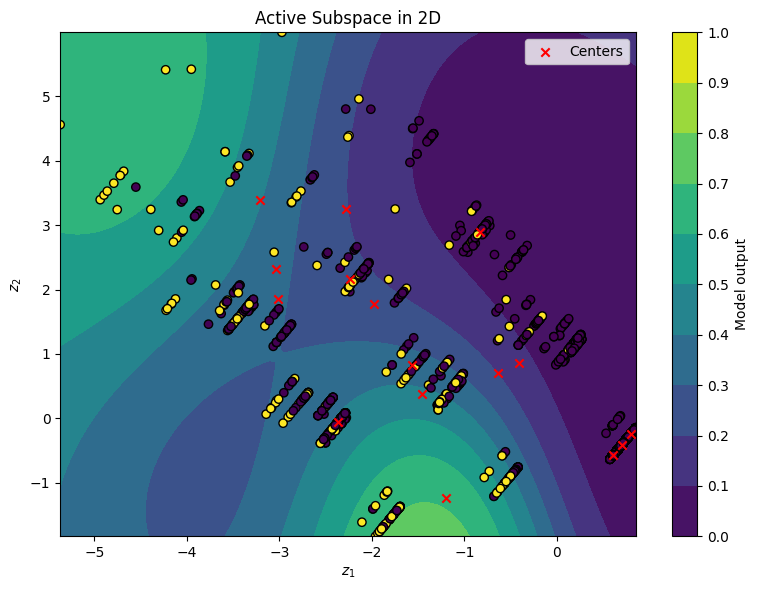

In [ ]:
# Plot contours

V = eigenvectors.detach().numpy()[:, ::-1] # sort eigenvectors
Z = np.dot(X_train_st, V[:, :2]) # project data into the latent or active subspace defined by the top-2 eigenvectors

lb1, ub1 = min(Z[:, 0]), max(Z[:, 0])
lb2, ub2 = min(Z[:, 1]), max(Z[:, 1])
xx1 = np.linspace(lb1, ub1, 100)
xx2 = np.linspace(lb2, ub2, 100)

XX1, XX2 = np.meshgrid(xx1, xx2)
xx12 = np.vstack([XX1.ravel(), XX2.ravel()]).T
xx12_back = np.dot(xx12, V[:, :2].T) # reproject back data from the active subspace so that we can evaluate the model
xx12_back = torch.tensor(xx12_back, dtype=torch.float32)

XX3 = model(xx12_back).detach().numpy().reshape(XX1.shape) # obtan the model output


fig, ax = plt.subplots(figsize=(8, 6))
# Plot centers
centers_projected = np.dot(model.centers.detach().numpy(), V[:, :2])

contours = plt.contourf(XX1, XX2, XX3, cmap='viridis', levels=np.linspace(0, 1, 11))
cbar = plt.colorbar(contours)
cbar.set_label('Model output')
cbar.set_ticks(np.linspace(0, 1, 11))

plt.scatter(Z[:, 0], Z[:, 1], c=y_train, edgecolors='black')
plt.scatter(centers_projected[:, 0], centers_projected[:, 1], c='red', marker='x', label='Centers')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.title('Active Subspace in 2D')
plt.legend()
plt.tight_layout()